In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple

## Class Declaration

### Error Function Class
This class sets the error function and its derivative based on the given `error_type` parameter. The error function is used to calculate the error of the neural network. The error function is defined as:

- **Mean Squared Error (MSE)**: The mean squared error is the average of the squared differences between the predicted and actual values. It is defined as: $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^2$$ and its derivative is: $$\frac{\partial MSE}{\partial y} = \frac{2}{n} * \sum_{i=1}^{n} (\hat{y}_{i} - y_{i})$$

- **Mean Absolute Error (MAE)**: The mean absolute error is the average of the absolute differences between the predicted and actual values. It is defined as: $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$$ and its derivative is: $$\frac{\partial MAE}{\partial y} = \frac{1}{n} * \sum_{i=1}^{n} sign(\hat{y}_{i} - y_{i})$$

In [194]:
class ErrorFunction:
  def __init__(self, error_type: str = 'mse') -> None:
    self.set_error_function(error_type)

  def set_error_function(self, error_type: str) -> None:
    if error_type == 'mse':
      self.func = self.mse
      self.dfunc = self.d_mse
    elif error_type == 'mae':
      self.func = self.mae
      self.dfunc = self.d_mae
    else:
      raise ValueError('Error function not found')

  def mse(self, y:np.ndarray, y_hat:np.ndarray) -> float:
    return np.mean(np.square(y - y_hat))

  def d_mse(self, y:np.ndarray, y_hat:np.ndarray) -> np.ndarray:
    return 2 * (y_hat - y) / y.size

  def mae(self, y:np.ndarray, y_hat:np.ndarray) -> float:
    return np.mean(np.abs(y - y_hat))

  def d_mae(self, y:np.ndarray, y_hat:np.ndarray) -> np.ndarray:
    return np.sign(y_hat - y) / y.size

In [195]:
class Layer:
  def __init__(self):
    self.inputs = None
    self.outputs = None

  def forward(self, inputs:np.ndarray) -> np.ndarray:
    raise NotImplementedError

  def backward(self, output_error:np.ndarray) -> np.ndarray:
    raise NotImplementedError

### Activation Function Class
This class sets the activation function and its derivative based on the given `activation_type` parameter. The activation function is used to introduce non-linearity to the neural network. The activation function is defined as:

- **Sigmoid**: The sigmoid function is a non-linear activation function that squashes the input values between 0 and 1. It is defined as: $$\sigma(x) = \frac{1}{1 + e^{-x}}$$ and its derivative is: $$\frac{\partial \sigma(x)}{\partial x} = \sigma(x) * (1 - \sigma(x))$$
- **ReLU**: The ReLU function is a non-linear activation function that returns 0 for negative values and the input value for positive values. It is defined as: $$ReLU(x) = max(0, x)$$ and its derivative is: $$\frac{\partial ReLU(x)}{\partial x} = 1 \text{ if } x > 0 \text{ else } 0$$
- **Tanh**: The tanh function is a non-linear activation function that squashes the input values between -1 and 1. It is defined as: $$tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$ and its derivative is: $$\frac{\partial tanh(x)}{\partial x} = 1 - tanh(x)^2$$
- **Linear**: The linear function is a linear activation function that returns the input value as it is. It is defined as: $$f(x) = x$$ and its derivative is: $$\frac{\partial f(x)}{\partial x} = 1$$

In [196]:
class Activation(Layer):
  def __init__(self, activation:str='sigmoid') -> None:
    self.set_activation(activation)

  def set_activation(self, activation:str) -> None:
    if activation == 'sigmoid':
      self.func = self.sigmoid
      self.dfunc = self.d_sigmoid
    elif activation == 'relu':
      self.func = self.relu
      self.dfunc = self.d_relu
    elif activation == 'tanh':
      self.func = self.tanh
      self.dfunc = self.d_tanh
    else:
      raise ValueError('Activation function not found')

  def forward(self, inputs:np.ndarray) -> np.ndarray:
    self.inputs = inputs
    self.outputs = self.func(inputs)
    return self.outputs

  def backward(self, output_error:np.ndarray, _) -> np.ndarray:
    return self.dfunc(self.inputs) * output_error

  def sigmoid(self, x:np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

  def d_sigmoid(self, x:np.ndarray) -> np.ndarray:
    return self.sigmoid(x) * (1 - self.sigmoid(x))

  def relu(self, x:np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

  def d_relu(self, x:np.ndarray) -> np.ndarray:
    return np.where(x > 0, 1, 0)

  def tanh(self, x:np.ndarray) -> np.ndarray:
    return np.tanh(x)

  def d_tanh(self, x:np.ndarray) -> np.ndarray:
    return 1 - np.square(np.tanh(x))

### NeuralLayer Class
This class defines the layer in the neural network, which consist of one or multiple neurons. It has the following attributes:
- `n_inputs`: The number of inputs to the layer.
- `n_neurons`: The number of neurons in the layer.
- `activation`: The activation function type for the neurons in the layer.

The class has the following methods:
- `__init__(self, n_inputs, n_neurons, activation)`: The constructor method that initializes the layer with the given number of inputs, number of neurons, and activation function type.
- `deltas(self)`: This method returns the delta values for all the neurons in the layer.
- `forward(self, inputs)`: This method calculates the output of the layer given the input values.
- `accumulate_gradient(self)`: This method accumulates the gradient for all the neurons in the layer.
- `update_weights(self, learning_rate, batch_size)`: This method updates the weights of all the neurons in the layer using the accumulated gradient and the learning rate.

In [197]:
class Dense(Layer):
  def __init__(self, input_size:int, output_size:int) -> None:
    self.weights = np.random.randn(input_size, output_size)
    self.biases = np.random.randn(1, output_size)

  def forward(self, inputs:np.ndarray) -> np.ndarray:
    self.inputs = inputs
    self.outputs = np.dot(self.inputs, self.weights) + self.biases
    return self.outputs

  def backward(self, output_error:np.ndarray, learning_rate: float) -> np.ndarray:
    input_error = np.dot(output_error, self.weights.T)
    weights_error = np.dot(self.inputs.T, output_error)

    self.weights -= learning_rate * weights_error
    self.biases -= learning_rate * output_error
    return input_error

### NeuralNetwork Class
This class defines the neural network, which consists of multiple layers. It has the following attributes:
- `layers`: The list of layers in the neural network.
- `error_function`: The error function type for the neural network.
- `learning_rate`: The learning rate for the neural network.
- `batch_size`: The batch size for the neural network.

The class has the following methods:
- `__init__(self, layers, error_function, learning_rate, batch_size)`: The constructor method that initializes the neural network with the given layers, error function type, learning rate, and batch size.
- `add(self, n_inputs, n_neurons, activation)`: This method adds a new layer to the neural network.
- `forward(self, inputs)`: This method calculates the output of the neural network given the input values.
- `backpropagation(self, targets)`: This method performs backpropagation to calculate the error and update the weights of the neural network.
- `accumulate_gradient(self)`: This method accumulates the gradient for all the layers in the neural network.
- `update_weights(self, batch_size)`: This method updates the weights of all the layers in the neural network using the accumulated gradient and the learning rate.
- `train(self, data, epochs, batch_size)`: This method trains the neural network on the given data for the specified number of epochs and batch size.
- `predict(self, data)`: This method predicts the output of the neural network on the given data.

In [198]:
class NeuralNetwork:
  def __init__(self, learning_rate: float = 0.01, error_type: str = 'mse', debug: bool = True) -> None:
    self.learning_rate = learning_rate
    self.debug = debug
    self.layers = []
    self.error_function = ErrorFunction(error_type)
    self.error_per_epoch = []

  def add(self, layer: Layer) -> None:
    self.layers.append(layer)

  def forward(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    error = 0
    d_error = 0

    for i in range(len(X)):
      output = X[i]

      for layer in self.layers:
        output = layer.forward(output)

      error += self.error_function.func(y[i], output)
      d_error += self.error_function.dfunc(y[i], output)

    return error / len(X), d_error / len(X)

  def backward(self, error: np.ndarray) -> None:
    for layer in reversed(self.layers):
      error = layer.backward(error, self.learning_rate)

  def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 100, batch_size: int = None, print_error: bool = True) -> None:
    print('\n> Training...')

    self.error_per_epoch = []
    n_samples = len(X)
    n_bacthes = n_samples // batch_size if batch_size else n_samples
    X_slices = np.array_split(X, n_bacthes)
    y_slices = np.array_split(y, n_bacthes)

    for epoch in range(epochs):
      err = 0

      for X_batch, y_batch in zip(X_slices, y_slices):
        error, d_error = self.forward(X_batch, y_batch)
        self.backward(d_error)
        err += error

      self.error_per_epoch.append(err / n_bacthes)

      if print_error:
        print(f'Epoch {epoch + 1}/{epochs} - Error: {err/n_bacthes}')

    print('\n> Training done!')

  def predict(self, X: np.ndarray) -> None:
    print('\n> Predicting...')

    results = []
    for data in X:
      output = data
      for layer in self.layers:
        output = layer.forward(output)

      results.append(output)

    print('\n> Prediction done!')
    return results


In [199]:
def test(net: NeuralNetwork, X_test: np.ndarray, y_test: np.ndarray) -> None:
  print('\n> Testing...')

  y_pred = net.predict(X_test)
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  mse = ErrorFunction().mse(y_test, y_pred)
  mae = ErrorFunction().mae(y_test, y_pred)

  table = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
  })

  print('\n> Results:')
  print(table)
  print(f'\nMSE: {mse}')
  print(f'MAE: {mae}')

  print('\n> Testing done!')

## Data Preprocessing
The data preprocessing steps include:
- Loading the data
- Remapping the categorical features to numerical values
- Normalizing the numerical features
- Splitting the data into training and testing sets
- Converting the data into numpy arrays

In [200]:
df = pd.read_csv('Housing.csv')
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [201]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [202]:
# normalized the dataset
def min_max_scaler(X):
  mn = np.min(X)
  mx = np.max(X)
  return (X - mn) / (mx - mn), mn, mx

def min_max_inverse(X, mn, mx):
  return X * (mx - mn) + mn

def replaceCategorial(df: pd.DataFrame, columns: List[str], mapping: dict) -> None:
  for column in columns:
    df[column] = df[column].map(mapping)

In [203]:
replaceCategorial(df, ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea'], { 'yes': 1, 'no': 0 })
replaceCategorial(df, ['furnishingstatus'], {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})

df, _, _ = min_max_scaler(df)
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.000000,0.000558,3.007519e-07,1.503759e-07,2.255639e-07,7.518797e-08,0.000000e+00,0.000000e+00,0.0,7.518797e-08,1.503759e-07,7.518797e-08,1.503759e-07
1,0.921053,0.000674,3.007519e-07,3.007519e-07,3.007519e-07,7.518797e-08,0.000000e+00,0.000000e+00,0.0,7.518797e-08,2.255639e-07,0.000000e+00,1.503759e-07
2,0.921053,0.000749,2.255639e-07,1.503759e-07,1.503759e-07,7.518797e-08,0.000000e+00,7.518797e-08,0.0,0.000000e+00,1.503759e-07,7.518797e-08,7.518797e-08
3,0.918421,0.000564,3.007519e-07,1.503759e-07,1.503759e-07,7.518797e-08,0.000000e+00,7.518797e-08,0.0,7.518797e-08,2.255639e-07,7.518797e-08,1.503759e-07
4,0.857895,0.000558,3.007519e-07,7.518797e-08,1.503759e-07,7.518797e-08,7.518797e-08,7.518797e-08,0.0,7.518797e-08,1.503759e-07,0.000000e+00,1.503759e-07


In [204]:
def train_test_split(X, y, test_size=0.25, seed=42):
  n = len(X)
  np.random.seed(seed)

  idx = np.random.permutation(n)
  split = int(n * (1 - test_size))

  X_train, X_test = X[idx[:split]], X[idx[split:]]
  y_train, y_test = y[idx[:split]], y[idx[split:]]
  return X_train, X_test, y_train, y_test

In [205]:
feature_columns = ['area', 'bedrooms', 'bathrooms',	'stories', 'mainroad', 'guestroom',	'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
label_columns = ['price']

X = np.array([[e] for e in df[feature_columns].values])
y = np.array([[e] for e in df[label_columns].values])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=13852946)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(436, 1, 12) (436, 1, 1) (109, 1, 12) (109, 1, 1)


In [206]:
errors = []

nn_single = NeuralNetwork(learning_rate=0.1, error_type='mse', debug=False)
nn_single.add(Dense(12, 32))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(32, 16))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(16, 8))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(8, 1))

nn_single.train(X_train, y_train, epochs=100, batch_size=1, print_error=True)

errors.append({'stochastic': nn_single.error_per_epoch})
test(nn_single, X_test, y_test)


> Training...
Epoch 1/100 - Error: 0.05720499443576732
Epoch 2/100 - Error: 0.03258474629466701
Epoch 3/100 - Error: 0.0316206800434592
Epoch 4/100 - Error: 0.031111911799054443
Epoch 5/100 - Error: 0.030779963064745956
Epoch 6/100 - Error: 0.030526836230170995
Epoch 7/100 - Error: 0.030305978035751188
Epoch 8/100 - Error: 0.030088483144010823
Epoch 9/100 - Error: 0.029850612978739283
Epoch 10/100 - Error: 0.029568480758610786
Epoch 11/100 - Error: 0.029219256097581744
Epoch 12/100 - Error: 0.02879582877277927
Epoch 13/100 - Error: 0.028334839712963522
Epoch 14/100 - Error: 0.027914857866100515
Epoch 15/100 - Error: 0.027593804157845875
Epoch 16/100 - Error: 0.02737235791276547
Epoch 17/100 - Error: 0.027223009577262407
Epoch 18/100 - Error: 0.02711975759592292
Epoch 19/100 - Error: 0.027045343711801846
Epoch 20/100 - Error: 0.026989366252282404
Epoch 21/100 - Error: 0.026945605636161368
Epoch 22/100 - Error: 0.02691025034743744
Epoch 23/100 - Error: 0.02688088150570773
Epoch 24/100 -

In [207]:
nn_mini = NeuralNetwork(learning_rate=0.1, error_type='mse', debug=False)
nn_mini.add(Dense(12, 32))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(32, 16))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(16, 8))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(8, 1))

nn_mini.train(X_train, y_train, epochs=100, batch_size=64, print_error=True)

errors.append({'mini-batch': nn_mini.error_per_epoch})
test(nn_mini, X_test, y_test)


> Training...
Epoch 1/100 - Error: 0.45673076414304253


Epoch 2/100 - Error: 0.02143104342857156
Epoch 3/100 - Error: 0.021431030483974208
Epoch 4/100 - Error: 0.021431020343737738
Epoch 5/100 - Error: 0.02143101020502185
Epoch 6/100 - Error: 0.021431000067825515
Epoch 7/100 - Error: 0.021430989932148387
Epoch 8/100 - Error: 0.02143097979799011
Epoch 9/100 - Error: 0.02143096966535038
Epoch 10/100 - Error: 0.021430959534228827
Epoch 11/100 - Error: 0.021430949404625112
Epoch 12/100 - Error: 0.021430939276538916
Epoch 13/100 - Error: 0.02143092914996989
Epoch 14/100 - Error: 0.0214309190249177
Epoch 15/100 - Error: 0.02143090890138201
Epoch 16/100 - Error: 0.02143089877936247
Epoch 17/100 - Error: 0.021430888658858754
Epoch 18/100 - Error: 0.021430878539870513
Epoch 19/100 - Error: 0.021430868422397414
Epoch 20/100 - Error: 0.02143085830643913
Epoch 21/100 - Error: 0.021430848191995294
Epoch 22/100 - Error: 0.021430838079065605
Epoch 23/100 - Error: 0.0214308279676497
Epoch 24/100 - Error: 0.021430817857747256
Epoch 25/100 - Error: 0.0214308

In [208]:
nn_full = NeuralNetwork(learning_rate=0.1, error_type='mse', debug=False)
nn_full.add(Dense(12, 32))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(32, 16))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(16, 8))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(8, 1))

nn_full.train(X_train, y_train, epochs=100)

errors.append({'full-batch': nn_full.error_per_epoch})
test(nn_full, X_test, y_test)


> Training...
Epoch 1/100 - Error: 0.03259993001173285
Epoch 2/100 - Error: 0.029499855551397537
Epoch 3/100 - Error: 0.02859543904592322
Epoch 4/100 - Error: 0.02808001224920449
Epoch 5/100 - Error: 0.02773113839224215
Epoch 6/100 - Error: 0.027466158299640008
Epoch 7/100 - Error: 0.027245258228988163
Epoch 8/100 - Error: 0.027045117570975667
Epoch 9/100 - Error: 0.02684946076755131
Epoch 10/100 - Error: 0.02664511579383314
Epoch 11/100 - Error: 0.02642069403493267
Epoch 12/100 - Error: 0.02616752773740692
Epoch 13/100 - Error: 0.025883203551351718
Epoch 14/100 - Error: 0.02557656797853625
Epoch 15/100 - Error: 0.025269218770426705
Epoch 16/100 - Error: 0.024987889874760832
Epoch 17/100 - Error: 0.024751548112154385
Epoch 18/100 - Error: 0.024564966685851657
Epoch 19/100 - Error: 0.024422344430474207
Epoch 20/100 - Error: 0.024314092767579065
Epoch 21/100 - Error: 0.024231173456773288
Epoch 22/100 - Error: 0.0241665441551179
Epoch 23/100 - Error: 0.02411513637620803
Epoch 24/100 - Er

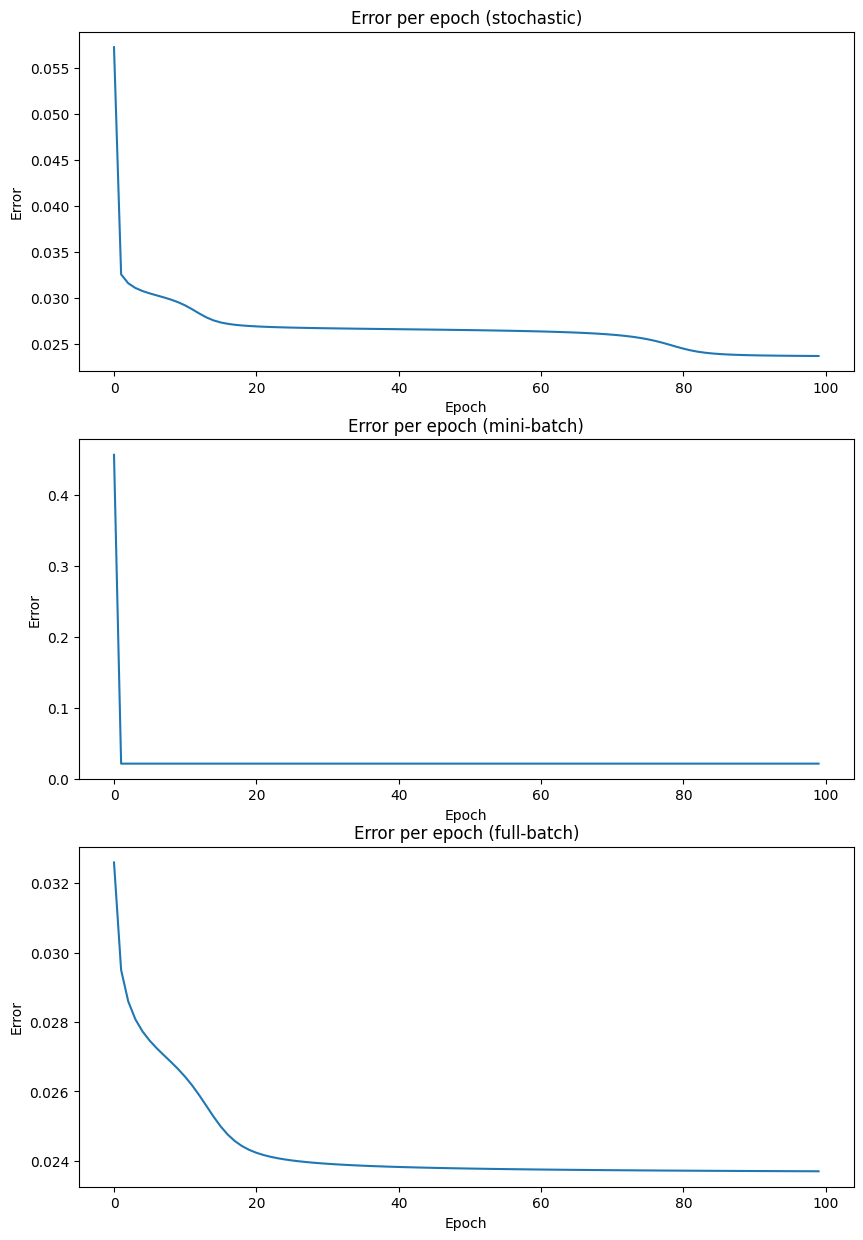

In [209]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for idx, error in enumerate(errors):
  axs[idx].plot(error[list(error.keys())[0]])
  axs[idx].set_title(f'Error per epoch ({list(error.keys())[0]})')
  axs[idx].set_xlabel('Epoch')
  axs[idx].set_ylabel('Error')

In [210]:
errors = []

nn_single = NeuralNetwork(learning_rate=0.1, error_type='mae', debug=False)
nn_single.add(Dense(12, 32))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(32, 16))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(16, 8))
nn_single.add(Activation('sigmoid'))
nn_single.add(Dense(8, 1))

nn_single.train(X_train, y_train, epochs=100, batch_size=1, print_error=True)

errors.append({'stochastic': nn_single.error_per_epoch})
test(nn_single, X_test, y_test)


> Training...
Epoch 1/100 - Error: 0.2390338527796161
Epoch 2/100 - Error: 0.21054683568471816
Epoch 3/100 - Error: 0.19463155769181378
Epoch 4/100 - Error: 0.1776691538270552
Epoch 5/100 - Error: 0.16962804598927875
Epoch 6/100 - Error: 0.16750207121874272
Epoch 7/100 - Error: 0.15411497741657304
Epoch 8/100 - Error: 0.14233773882186837
Epoch 9/100 - Error: 0.13812252883517823
Epoch 10/100 - Error: 0.14039451477494688
Epoch 11/100 - Error: 0.14012652054904104
Epoch 12/100 - Error: 0.1399532143520815
Epoch 13/100 - Error: 0.13970830818425523
Epoch 14/100 - Error: 0.13961380280921
Epoch 15/100 - Error: 0.13953896822183337
Epoch 16/100 - Error: 0.13947797654863014
Epoch 17/100 - Error: 0.13942716221907636
Epoch 18/100 - Error: 0.13938408349914877
Epoch 19/100 - Error: 0.13934704121803507
Epoch 20/100 - Error: 0.13931481135912577
Epoch 21/100 - Error: 0.1392864870311612
Epoch 22/100 - Error: 0.13926138038736363
Epoch 23/100 - Error: 0.13923895926643015
Epoch 24/100 - Error: 0.13921880487

In [211]:
nn_mini = NeuralNetwork(learning_rate=0.1, error_type='mae', debug=False)
nn_mini.add(Dense(12, 32))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(32, 16))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(16, 8))
nn_mini.add(Activation('sigmoid'))
nn_mini.add(Dense(8, 1))

nn_mini.train(X_train, y_train, epochs=100, batch_size=64, print_error=True)

errors.append({'mini-batch': nn_mini.error_per_epoch})
test(nn_mini, X_test, y_test)


> Training...
Epoch 1/100 - Error: 1.2633221449396936
Epoch 2/100 - Error: 0.373053915479779
Epoch 3/100 - Error: 0.35051093703799524
Epoch 4/100 - Error: 0.33002199924484804
Epoch 5/100 - Error: 0.30812156744134384
Epoch 6/100 - Error: 0.28876603511175913
Epoch 7/100 - Error: 0.27754605711078617
Epoch 8/100 - Error: 0.2667968109560915
Epoch 9/100 - Error: 0.260124007770337
Epoch 10/100 - Error: 0.25408193404760554
Epoch 11/100 - Error: 0.25097633394451074
Epoch 12/100 - Error: 0.24431545915761346
Epoch 13/100 - Error: 0.24222401859609213
Epoch 14/100 - Error: 0.23454487611903274
Epoch 15/100 - Error: 0.23127209801556112
Epoch 16/100 - Error: 0.22824907151379392
Epoch 17/100 - Error: 0.22526839710668486
Epoch 18/100 - Error: 0.22464938933515746
Epoch 19/100 - Error: 0.2219682730713929
Epoch 20/100 - Error: 0.21778247377751414
Epoch 21/100 - Error: 0.21706682662486895
Epoch 22/100 - Error: 0.21638511447346698
Epoch 23/100 - Error: 0.21592617891968902
Epoch 24/100 - Error: 0.21498339513

In [212]:
nn_full = NeuralNetwork(learning_rate=0.1, error_type='mae', debug=False)
nn_full.add(Dense(12, 32))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(32, 16))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(16, 8))
nn_full.add(Activation('sigmoid'))
nn_full.add(Dense(8, 1))

nn_full.train(X_train, y_train, epochs=100, print_error=True)

errors.append({'full-batch': nn_full.error_per_epoch})
test(nn_full, X_test, y_test)


> Training...
Epoch 1/100 - Error: 0.30281651637730844
Epoch 2/100 - Error: 0.267086492906841
Epoch 3/100 - Error: 0.24418232576844098
Epoch 4/100 - Error: 0.23518506418034663
Epoch 5/100 - Error: 0.21731648650828422
Epoch 6/100 - Error: 0.208017943434786
Epoch 7/100 - Error: 0.19442836121718876
Epoch 8/100 - Error: 0.1793203600478118
Epoch 9/100 - Error: 0.17507941733968166
Epoch 10/100 - Error: 0.17081632004342345
Epoch 11/100 - Error: 0.17130340019781548
Epoch 12/100 - Error: 0.16780273064015
Epoch 13/100 - Error: 0.1632358838782349
Epoch 14/100 - Error: 0.1535438056358968
Epoch 15/100 - Error: 0.14032917716873963
Epoch 16/100 - Error: 0.1388107702254072
Epoch 17/100 - Error: 0.13854113017209974
Epoch 18/100 - Error: 0.13848462202892056
Epoch 19/100 - Error: 0.1384265972899336
Epoch 20/100 - Error: 0.13908050329030708
Epoch 21/100 - Error: 0.13926320798802572
Epoch 22/100 - Error: 0.13858721684351674
Epoch 23/100 - Error: 0.1385034192024794
Epoch 24/100 - Error: 0.1384372815747897


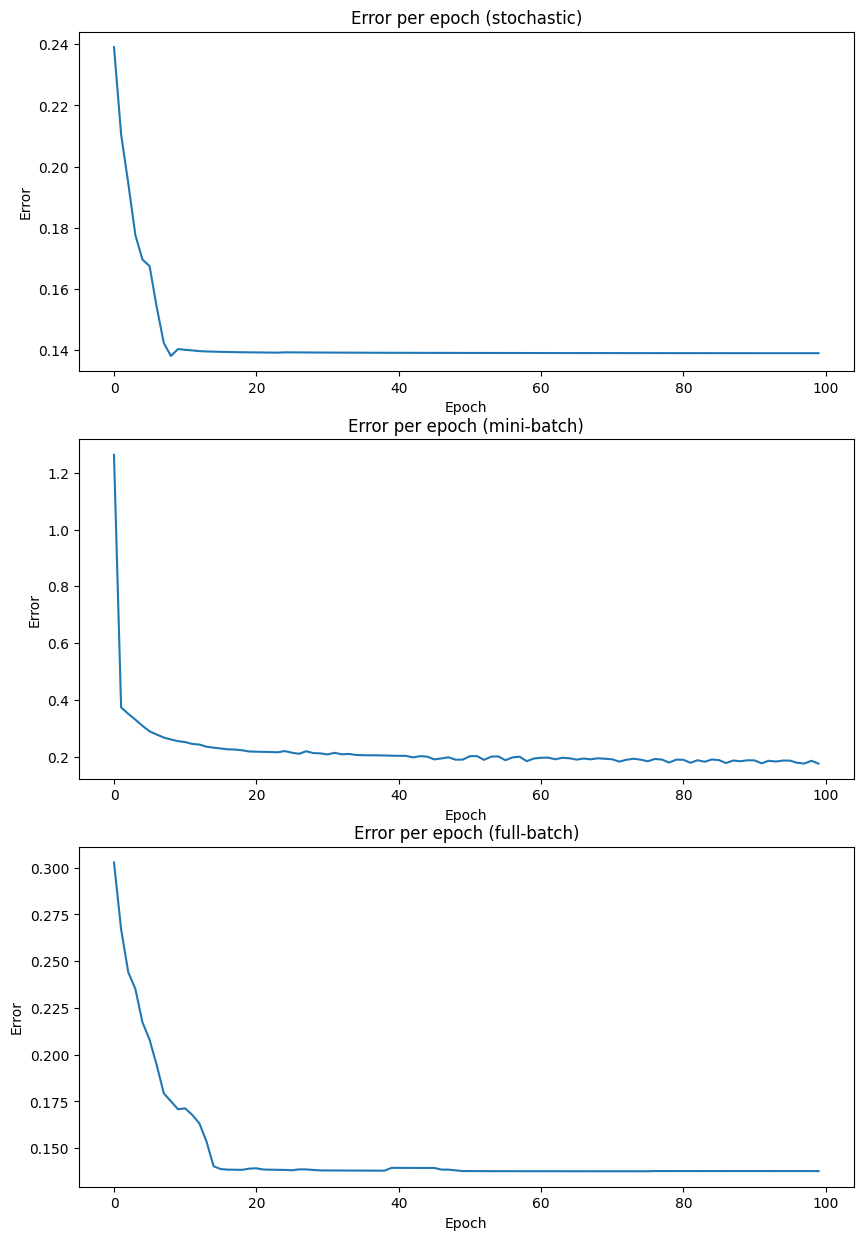

In [213]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for idx, error in enumerate(errors):
  axs[idx].plot(error[list(error.keys())[0]])
  axs[idx].set_title(f'Error per epoch ({list(error.keys())[0]})')
  axs[idx].set_xlabel('Epoch')
  axs[idx].set_ylabel('Error')